# RandAug:  automated data augmentation with reduced search space
In this application, we are demonstrating automated augmentation as proposed [here](https://arxiv.org/abs/1909.13719). 

The core idea of the paper is that it parameterizes data augmentation into two parameters: M and N. M represents the global augmentation intensity, which controls the magnitude of each augmentation. N represents the number of augmenting transformation to be applied. 

## Import the required libraries

In [28]:
import random

import numpy as np
from PIL import Image, ImageEnhance, ImageOps, ImageTransform

import fastestimator as fe
from fastestimator.dataset.data.cifair10 import load_data
from fastestimator.op.numpyop import NumpyOp
from fastestimator.op.numpyop.meta import OneOf
from fastestimator.op.numpyop.univariate import ChannelTranspose, Normalize
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.metric import Accuracy

## Define the transformations
Each transformation is randomly selected from the following 14 operations, the official source code can be found [here](https://github.com/tensorflow/tpu/blob/dc08f72654610ac932345f32b9c979031fb720bb/models/official/efficientnet/autoaugment.py).
* Identity
* Rotate
* Posterize
* Sharpness
* AutoContrast
* Solarize
* Contrast
* Equalize
* Color
* Brightness
* Shear-x
* Shear-y
* Translate-x
* Translate-y

On top of that, we use argument `level` to control the intensity of each augmentation. 

In [29]:
class Rotate(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.degree = level * 3.0

    def forward(self, data, state):
        im = Image.fromarray(data)
        degree = self.degree * random.choice([1.0, -1.0])
        im = im.rotate(degree)
        return np.asarray(im)


class Identity(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)


class AutoContrast(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        im = Image.fromarray(data)
        im = ImageOps.autocontrast(im)
        return np.copy(np.asarray(im))


class Equalize(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        im = Image.fromarray(data)
        im = ImageOps.equalize(im)
        return np.copy(np.asarray(im))


class Posterize(NumpyOp):
    # resuce the number of bits for each channel, this may be inconsistent with original implementation
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.bits = 8 - int((level / 10) * 4)

    def forward(self, data, state):
        im = Image.fromarray(data)
        im = ImageOps.posterize(im, self.bits)
        return np.copy(np.asarray(im))


class Solarize(NumpyOp):
    # this may be inconsistent with original implementation
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.threshold = 256 - int(level * 25.6)

    def forward(self, data, state):
        data = np.where(data < self.threshold, data, 255 - data)
        return data


class Sharpness(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.diff = 0.09 * level

    def forward(self, data, state):
        im = Image.fromarray(data)
        factor = 1.0 + self.diff * random.choice([1.0, -1.0])
        im = ImageEnhance.Sharpness(im).enhance(factor)
        return np.copy(np.asarray(im))


class Contrast(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.diff = 0.09 * level

    def forward(self, data, state):
        im = Image.fromarray(data)
        factor = 1.0 + self.diff * random.choice([1.0, -1.0])
        im = ImageEnhance.Contrast(im).enhance(factor)
        return np.copy(np.asarray(im))


class Color(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.diff = 0.09 * level

    def forward(self, data, state):
        im = Image.fromarray(data)
        factor = 1.0 + self.diff * random.choice([1.0, -1.0])
        im = ImageEnhance.Color(im).enhance(factor)
        return np.copy(np.asarray(im))


class Brightness(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.diff = 0.09 * level

    def forward(self, data, state):
        im = Image.fromarray(data)
        factor = 1.0 + self.diff * random.choice([1.0, -1.0])
        im = ImageEnhance.Brightness(im).enhance(factor)
        return np.copy(np.asarray(im))


class ShearX(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.shear_coef = level * 0.03

    def forward(self, data, state):
        im = Image.fromarray(data)
        shear_coeff = self.shear_coef * random.choice([1.0, -1.0])
        width, height = im.size
        xshift = int(round(self.shear_coef * width))
        new_width = width + xshift
        im = im.transform((new_width, height),
                          ImageTransform.AffineTransform(
                              (1.0, shear_coeff, -xshift if shear_coeff > 0 else 0.0, 0.0, 1.0, 0.0)),
                          resample=Image.BICUBIC)
        if self.shear_coef > 0:
            im = im.resize((width, height))
        return np.copy(np.asarray(im))


class ShearY(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.shear_coef = level * 0.03

    def forward(self, data, state):
        im = Image.fromarray(data)
        shear_coeff = self.shear_coef * random.choice([1.0, -1.0])
        width, height = im.size
        yshift = int(round(self.shear_coef * height))
        newheight = height + yshift
        im = im.transform((width, newheight),
                          ImageTransform.AffineTransform(
                              (1.0, 0.0, 0.0, shear_coeff, 1.0, -yshift if shear_coeff > 0 else 0.0)),
                          resample=Image.BICUBIC)
        if self.shear_coef > 0:
            im = im.resize((width, height))
        return np.copy(np.asarray(im))


class TranslateX(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.level = level

    def forward(self, data, state):
        im = Image.fromarray(data)
        width, height = im.size
        displacement = int(self.level / 10 * width / 3 * random.choice([1.0, -1.0]))
        im = im.transform((width, height),
                          ImageTransform.AffineTransform((1.0, 0.0, displacement, 0.0, 1.0, 0.0)),
                          resample=Image.BICUBIC)
        return np.copy(np.asarray(im))


class TranslateY(NumpyOp):
    def __init__(self, level, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.level = level

    def forward(self, data, state):
        im = Image.fromarray(data)
        width, height = im.size
        displacement = int(self.level / 10 * height / 3 * random.choice([1.0, -1.0]))
        im = im.transform((width, height),
                          ImageTransform.AffineTransform((1.0, 0.0, 0.0, 0.0, 1.0, displacement)),
                          resample=Image.BICUBIC)
        return np.copy(np.asarray(im))

## Create Pipeline
We will use `OneOf` Op to randomly select 1 among 14 augmentations, then apply the `OneOf` for N (num_augment) times. After that, we will use `Normalize` to scale down the pixel values and finally `ChannelTranspose` to make image data channel-first.

In [30]:
def get_pipeline(level, num_augment, batch_size):
    assert 0 <= level <= 10, "the level should be between 0 and 10"
    train_data, test_data = load_data()
    aug_ops = [
        OneOf(
            Rotate(level=level, inputs="x", outputs="x", mode="train"),
            Identity(level=level, inputs="x", outputs="x", mode="train"),
            AutoContrast(level=level, inputs="x", outputs="x", mode="train"),
            Equalize(level=level, inputs="x", outputs="x", mode="train"),
            Posterize(level=level, inputs="x", outputs="x", mode="train"),
            Solarize(level=level, inputs="x", outputs="x", mode="train"),
            Sharpness(level=level, inputs="x", outputs="x", mode="train"),
            Contrast(level=level, inputs="x", outputs="x", mode="train"),
            Color(level=level, inputs="x", outputs="x", mode="train"),
            Brightness(level=level, inputs="x", outputs="x", mode="train"),
            ShearX(level=level, inputs="x", outputs="x", mode="train"),
            ShearY(level=level, inputs="x", outputs="x", mode="train"),
            TranslateX(level=level, inputs="x", outputs="x", mode="train"),
            TranslateY(level=level, inputs="x", outputs="x", mode="train"),
        ) for _ in range(num_augment)
    ]
    pipeline = fe.Pipeline(
        train_data=train_data,
        test_data=test_data,
        batch_size=batch_size,
        ops=aug_ops + [
            Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
            ChannelTranspose(inputs="x", outputs="x"),
        ])
    return pipeline

### Visualize Preprocessing Results
In order to make sure the pipeline works as expected, we need to visualize its output. `Pipeline.get_results` will return a batch of pipeline output, then we use `fe.util.ImgData` to visualize the result:

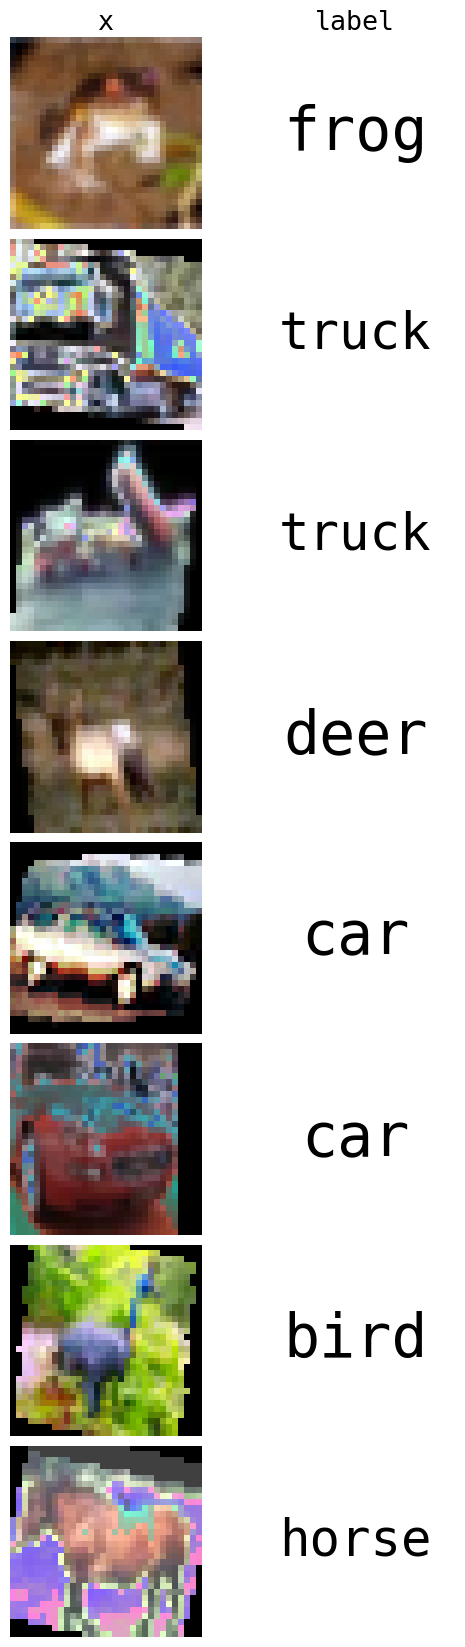

In [31]:
from matplotlib import pyplot as plt

pipeline = get_pipeline(level=4, num_augment=4, batch_size=8)
data = pipeline.get_results()
class_dictionary = {
    0: "airplane", 1: "car", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}
y = np.array([class_dictionary[clazz.item()] for clazz in fe.util.to_number(data["y"])])
images = fe.util.ImgData(x=data["x"], label=y)
fig = images.paint_figure()
plt.show()

## `Network` construction

In this example, we will use the same network setup as the Fast Cifar10 example.

In [32]:
from fastestimator.architecture.pytorch import ResNet9

def get_network():
    model = fe.build(model_fn=ResNet9, optimizer_fn="adam")
    network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce")
    ])
    return network

## Putting everything together
Now we are ready to combine every pieces together by creating an estimator instance:

In [33]:
def get_estimator(level,
                  num_augment,
                  epochs=24,
                  batch_size=512,
                  train_steps_per_epoch=None,
                  eval_steps_per_epoch=None):
    pipeline = get_pipeline(batch_size=batch_size, level=level, num_augment=num_augment)
    network = get_network()
    estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=epochs,
                             traces=Accuracy(true_key="y", pred_key="y_pred"),
                             train_steps_per_epoch=train_steps_per_epoch,
                             eval_steps_per_epoch=eval_steps_per_epoch)
    return estimator

## Applying Grid Search to find the best level(M) and num_augment(N):
As suggested by the paper, N and M ranges from 1 to 10, grid search can be used effectively to find the best parameter. Running 100 experiments takes ~20 hours on single V100 GPU.

In [ ]:
#training parameters
epochs = 50
batch_size = 512
train_steps_per_epoch = None
eval_steps_per_epoch = None
max_level = 10
max_num_augment = 10
final_step = 4900

In [ ]:
result = np.zeros(shape=(max_level, max_num_augment))
for level in range(1, max_level+1):
    for num_augment in range(1, max_num_augment + 1):
        print("Trying level {} and num_augment {}".format(level, num_augment))
        est = get_estimator(level=level, 
                            num_augment=num_augment, 
                            epochs=epochs, 
                            train_steps_per_epoch=train_steps_per_epoch, 
                            eval_steps_per_epoch=eval_steps_per_epoch, 
                            batch_size=batch_size)
        est.fit(summary="exp")
        hist = est.test(summary="exp")
        result[level - 1, num_augment - 1] = hist.history["test"]["accuracy"][final_step]

## Visualize the grid search results:

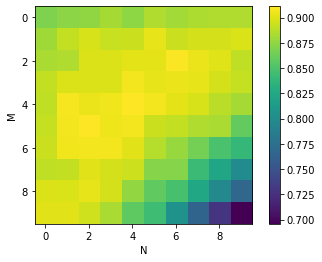

In [34]:
plt.imshow(result)
plt.colorbar(orientation='vertical')
plt.xlabel("N")
plt.ylabel("M")
plt.show()